In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-05 03:44:21.171832: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-05 03:44:21.991910: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-05 03:44:22.039798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-05 03:44:22.039845: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-05 03:44:22.043976: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-05 03:44:22.044041: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-05 03:44:22.046003: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

redd_gen_GASF_60m_300S0X_R42_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 0.9442708333333333, 1: 2.8383561643835615, 2: 0.5683385579937305, 3: 5.824899598393574, 4: 0.6033277870216306}
 
Tests 
fridge/freezer test: 384 train: 1536
electric furnace test: 128 train: 511
light test: 638 train: 2552
microwave test: 62 train: 249
sockets test: 601 train: 2404


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/redd/TL/redd_42_refit, iawe, eco, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data redd training on model refit seed 42
reading data, printing stats: 
['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 0.9442708333333333, 1: 2.8383561643835615, 2: 0.5683385579937305, 3: 5.824899598393574, 4: 0.6033277870216306}
 
Tests 
fridge/freezer test: 384 train: 1536
electric furnace test: 128 train: 511
light test: 638 train: 2552
microwave test: 62 train: 249
sockets test: 601 train: 2404
loading model
compling TL model..


2022-02-05 03:44:23.003180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-05 03:44:23.003513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-05 03:44:23.003565: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-05 03:44:23.368129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-05 03:44:23.368164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-05 03:44:23.368171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-05 03:44:23.368743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-05 03:44:23.955805: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-05 03:44:23.976562: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-05 03:44:24.462744: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-05 03:44:24.936541: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-05 03:44:25.417066: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-05 03:44:25.841859: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


907/907 - 16s - loss: 0.9325 - accuracy: 0.6238
Epoch 2/50
907/907 - 15s - loss: 0.6155 - accuracy: 0.7070
Epoch 3/50
907/907 - 14s - loss: 0.5828 - accuracy: 0.7272
Epoch 4/50
907/907 - 15s - loss: 0.5174 - accuracy: 0.7481
Epoch 5/50
907/907 - 14s - loss: 0.4947 - accuracy: 0.7489
Epoch 6/50
907/907 - 14s - loss: 0.4353 - accuracy: 0.7708
Epoch 7/50
907/907 - 14s - loss: 0.4407 - accuracy: 0.7765
Epoch 8/50
907/907 - 14s - loss: 0.4208 - accuracy: 0.7777
Epoch 9/50
907/907 - 14s - loss: 0.4054 - accuracy: 0.7899
Epoch 10/50
907/907 - 14s - loss: 0.3903 - accuracy: 0.7889
Epoch 11/50
907/907 - 15s - loss: 0.3852 - accuracy: 0.7991
Epoch 12/50
907/907 - 14s - loss: 0.3957 - accuracy: 0.7947
Epoch 13/50
907/907 - 14s - loss: 0.3640 - accuracy: 0.8030
Epoch 14/50
907/907 - 15s - loss: 0.3469 - accuracy: 0.8140
Epoch 15/50
907/907 - 14s - loss: 0.3415 - accuracy: 0.8152
Epoch 16/50
907/907 - 14s - loss: 0.3979 - accuracy: 0.8025
Epoch 17/50
907/907 - 14s - loss: 0.3325 - accuracy: 0.8227


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.5666 - accuracy: 0.4748
Epoch 2/50
907/907 - 15s - loss: 1.2088 - accuracy: 0.5178
Epoch 3/50
907/907 - 15s - loss: 1.1741 - accuracy: 0.5670
Epoch 4/50
907/907 - 14s - loss: 1.1986 - accuracy: 0.5312
Epoch 5/50
907/907 - 15s - loss: 1.1111 - accuracy: 0.5822
Epoch 6/50
907/907 - 15s - loss: 1.0778 - accuracy: 0.5831
Epoch 7/50
907/907 - 15s - loss: 1.1071 - accuracy: 0.5644
Epoch 8/50
907/907 - 14s - loss: 1.0081 - accuracy: 0.5949
Epoch 9/50
907/907 - 15s - loss: 0.9779 - accuracy: 0.6147
Epoch 10/50
907/907 - 14s - loss: 0.9475 - accuracy: 0.6382
Epoch 11/50
907/907 - 14s - loss: 0.9788 - accuracy: 0.5998
Epoch 12/50
907/907 - 14s - loss: 0.8929 - accuracy: 0.6502
Epoch 13/50
907/907 - 15s - loss: 0.8669 - accuracy: 0.6518
Epoch 14/50
907/907 - 15s - loss: 0.8908 - accuracy: 0.6329
Epoch 15/50
907/907 - 15s - loss: 0.8594 - accuracy: 0.6389
Epoch 16/50
907/907 - 14s - loss: 0.8197 - accuracy: 0.6492
Epoch 17/50
907/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.2001 - accuracy: 0.5283
Epoch 2/50
907/907 - 14s - loss: 0.8862 - accuracy: 0.6755
Epoch 3/50
907/907 - 15s - loss: 0.7905 - accuracy: 0.7106
Epoch 4/50
907/907 - 15s - loss: 0.7028 - accuracy: 0.7232
Epoch 5/50
907/907 - 15s - loss: 0.6235 - accuracy: 0.7370
Epoch 6/50
907/907 - 15s - loss: 0.6401 - accuracy: 0.7140
Epoch 7/50
907/907 - 14s - loss: 0.6087 - accuracy: 0.7351
Epoch 8/50
907/907 - 14s - loss: 0.5245 - accuracy: 0.7609
Epoch 9/50
907/907 - 14s - loss: 0.5240 - accuracy: 0.7643
Epoch 10/50
907/907 - 15s - loss: 0.5350 - accuracy: 0.7743
Epoch 11/50
907/907 - 15s - loss: 0.4804 - accuracy: 0.7769
Epoch 12/50
907/907 - 14s - loss: 0.4438 - accuracy: 0.7885
Epoch 13/50
907/907 - 15s - loss: 0.4550 - accuracy: 0.7984
Epoch 14/50
907/907 - 14s - loss: 0.4174 - accuracy: 0.8061
Epoch 15/50
907/907 - 14s - loss: 0.3975 - accuracy: 0.8093
Epoch 16/50
907/907 - 15s - loss: 0.4006 - accuracy: 0.8049
Epoch 17/50
907/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
907/907 - 15s - loss: 1.0039 - accuracy: 0.5867
Epoch 2/50
907/907 - 14s - loss: 0.7208 - accuracy: 0.6708
Epoch 3/50
907/907 - 14s - loss: 0.6366 - accuracy: 0.6926
Epoch 4/50
907/907 - 14s - loss: 0.6361 - accuracy: 0.7255
Epoch 5/50
907/907 - 14s - loss: 0.5278 - accuracy: 0.7358
Epoch 6/50
907/907 - 15s - loss: 0.4781 - accuracy: 0.7736
Epoch 7/50
907/907 - 14s - loss: 0.4702 - accuracy: 0.7772
Epoch 8/50
907/907 - 14s - loss: 0.4630 - accuracy: 0.7730
Epoch 9/50
907/907 - 14s - loss: 0.4552 - accuracy: 0.7787
Epoch 10/50
907/907 - 14s - loss: 0.3921 - accuracy: 0.8097
Epoch 11/50
907/907 - 14s - loss: 0.3692 - accuracy: 0.8079
Epoch 12/50
907/907 - 15s - loss: 0.3768 - accuracy: 0.8170
Epoch 13/50
907/907 - 15s - loss: 0.3759 - accuracy: 0.8141
Epoch 14/50
907/907 - 15s - loss: 0.3471 - accuracy: 0.8275
Epoch 15/50
907/907 - 14s - loss: 0.3441 - accuracy: 0.8325
Epoch 16/50
907/907 - 14s - loss: 0.3196 - accuracy: 0.8392
Epoch 17/50
907/

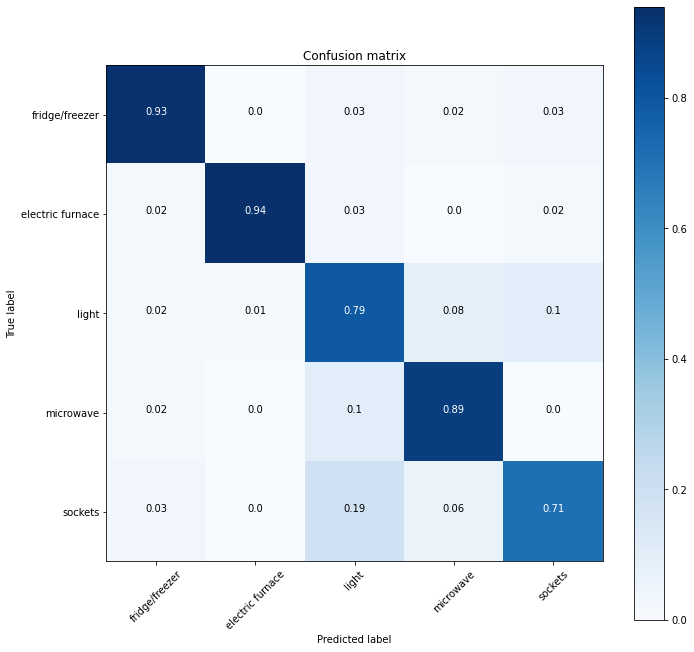

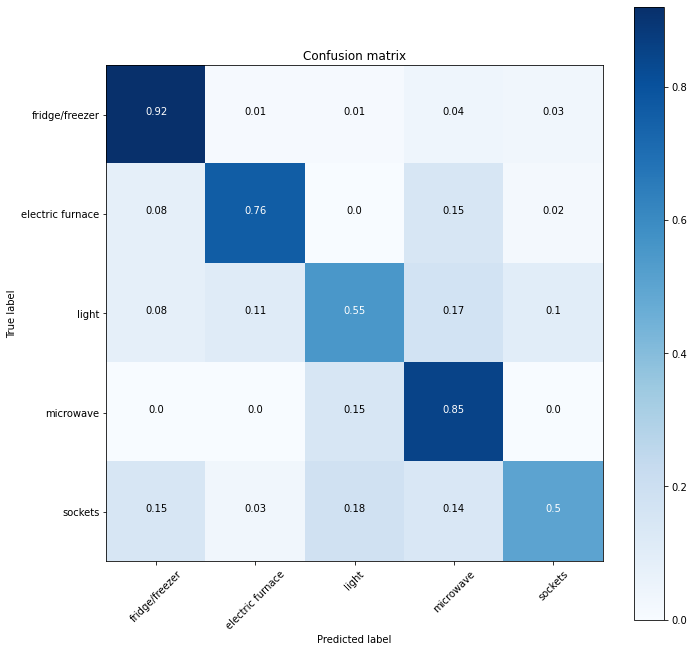

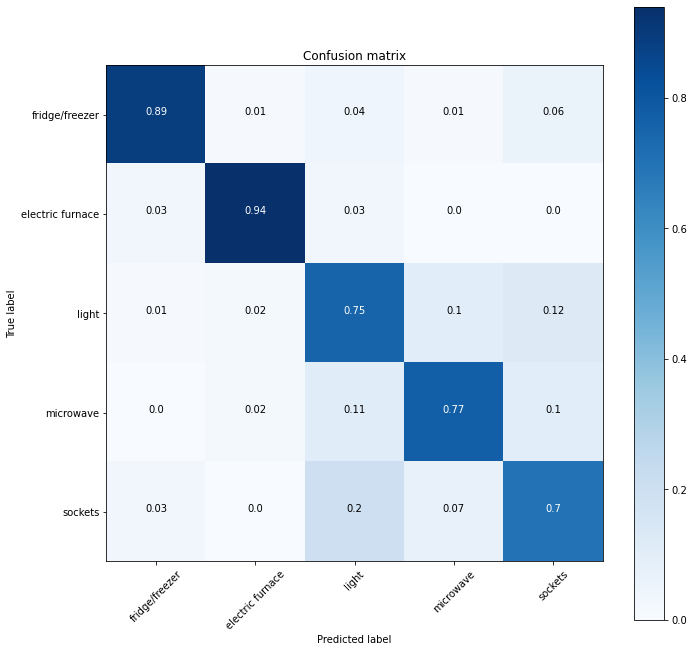

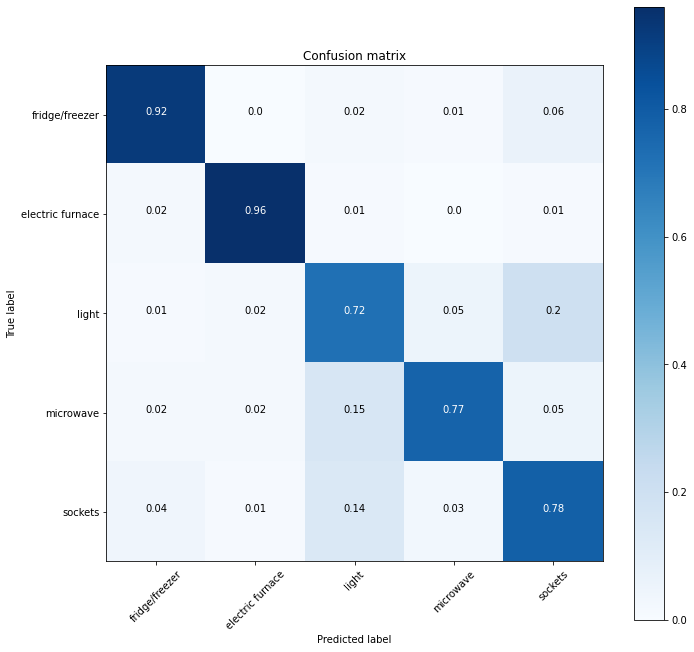

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()